In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from utils.traditions import *


In [2]:
def jacobi_2nd(A, b, x0, tol=1e-8, max_iterations=1000):
    x = x0
    D = sparse.diags(A.diagonal()).tocsc()
    invD = sparse.linalg.inv(D)
    LU = A - D
    for k in range(max_iterations):     
        x_new = invD@(b - LU@x)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x

def gauess_seidel(A, b, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    L = sparse.tril(A)
    U = sparse.triu(A, 1)
    
    Linv = sparse.linalg.inv((L).tocsc())

    for k in range(max_iterations):     
        x_new = Linv @ (b - U@x)
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x

def cg(A, b, x, tol=1e-8, max_iter=1000):
#     x = np.zeros_like(b, dtype=np.double)
    r = b - A@x
    p = r
    for k in range(max_iter):
        if np.linalg.norm(r) < tol:
            break
        alpha = (r.T@r)/(p.T@A@p)
        x_new = x + alpha * p
        r1 = r - alpha * A @ p
        beta = (r1.T@r1)/(r.T@r)
        p = r1 + beta * p
        r = r1    
        
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x


def my_cg(A, b, x, y, tol=1e-9, big_iter=100, small_iter=20):
    u0 = np.linalg.norm(x - y)
    for k in range(big_iter):
        x_new = cg(A, b, x, max_iter=small_iter)
        diff = np.linalg.norm(x_new - x)
        loss = np.linalg.norm(A@x_new - b)
        u = np.linalg.norm(x_new - y) / u0
        print(f'itr:{k:<5},Difference:{diff:<10.3e}, Loss:{loss:<10.2e},Speed:{u:<10.2e}')
        if loss < tol:    break
        x = x_new
    return x
    

def descent(A, b, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b)
    r = b - A@x
    for k in range(max_iterations):
        alpha = (r.T@r)/(r.T@A@r)
        x_new = x + alpha * r
        r = b - A@x_new
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x
    

def sor(A, b, w=0.5, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    D = sparse.diags(A.diagonal()).tocsc()
    L = sparse.tril(A, 1)
    U = sparse.triu(A, 1)
    invM = sparse.linalg.inv((D + w*L))
    
    for k in range(max_iterations):
        x_new = invM @ ((-w*U + (1-w)*D)@x + w*b)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k:5} Difference:{diff:15.3e},  Loss:{loss:15.2e}')
        if loss < tol:    break
        x = x_new
    return x

def ssor(A, b, w=0.5, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    D = sparse.diags(A.diagonal()).tocsc()
    L = sparse.tril(A, 1)
    U = sparse.triu(A, 1)
    invM1 = sparse.linalg.inv((D + w*L).tocsc())
    invM2 = sparse.linalg.inv((D + w*U).tocsc())
    
    for k in range(max_iterations):
        x_half = invM1 @ ((-w*U + (1-w)*D)@x + w*b)
        x_new = invM2 @ ((-w*L + (1-w)*D)@x + w*b)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x

def is_pos_def(x):
    return np.all(sparse.linalg.eigs(x)[0] > 0)

In [5]:
A = sparse.load_npz('./data/64/mat/fd_AD.npz').tocsc()
valB = np.load('./data/64/mixed/fd_ValB.npy')
B = np.load('./data/64/mixed/fd_B.npy')
# valR = np.zeros_like(valB)
# R = np.zeros_like(B)
    

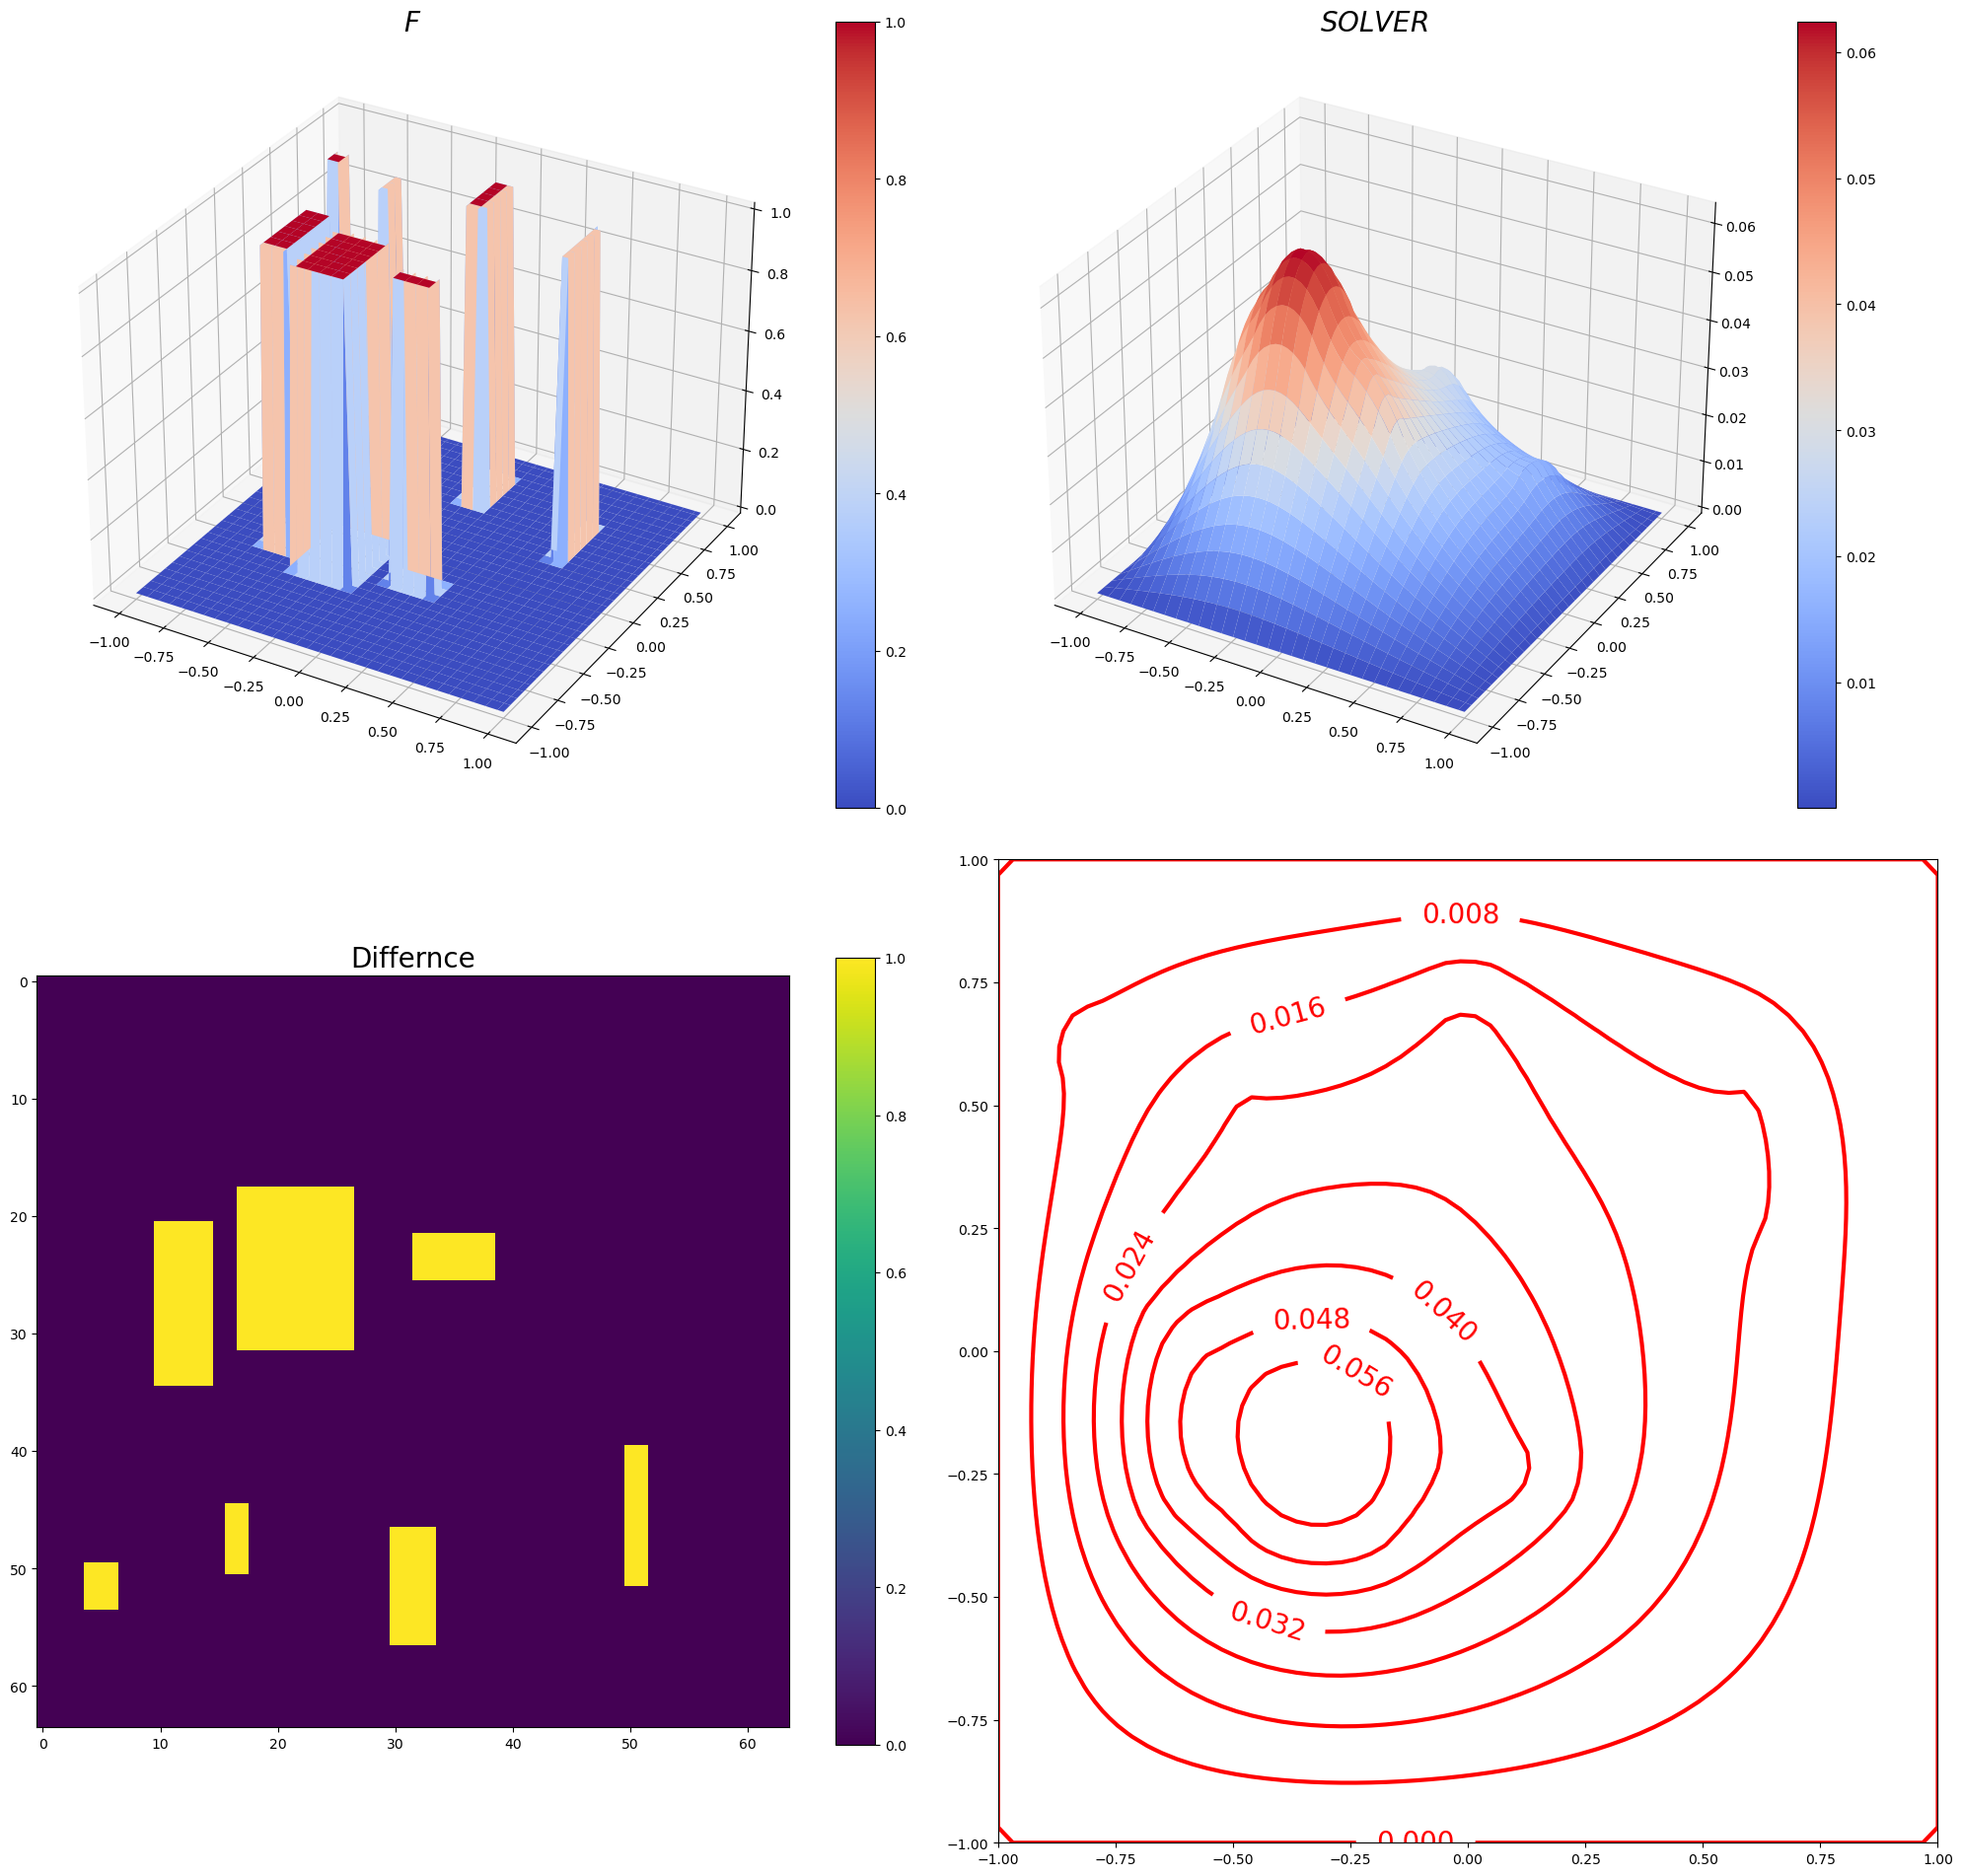

In [15]:
a = 1
n = 64
label = 'block'
x = np.linspace(-a, a, n)
y = np.linspace(-a, a, n)
xx, yy = np.meshgrid(x, y)

F = np.load(f'./data/{n}/{label}/fd_F.npy')
B = np.load(f'./data/{n}/{label}/fd_B.npy')
U = np.load(f'./data/{n}/{label}/fd_XN.npy')
# A = sparse.load_npz('./data/64/mat/fd_AD.npz').tocsc()
A = fd_A_dir(n).tocsc()


idx = 10
f, b, u = F[idx], B[idx], U[idx]

u = spsolve(A, b).reshape(n, n)

fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
# g = normal(f[0], f[1], h=0.08)
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.set_title(f'$F$', fontsize=20)
surf_bc = ax1.plot_surface(xx, yy, f, cmap=cm.coolwarm,)
plt.colorbar(surf_bc, shrink=0.8, ax=ax1)

ax2.set_title(f'$SOLVER$', fontsize=20)
surf = ax2.plot_surface(xx, yy, u, cmap=cm.coolwarm,)
plt.colorbar(surf, shrink=0.8, ax=ax2)

ax3.set_title(f'Differnce', fontsize=20)
im = ax3.imshow(f)
plt.colorbar(im, shrink=0.8, ax=ax3)

# ct1 = ax4.contour(xx, yy, w, colors='b', linewidths=2)
ct2 = ax4.contour(xx, yy, u, colors='r', linewidths=3)
# ax4.clabel(ct1, inline=True, fontsize=20)
ax4.clabel(ct2, inline=True, fontsize=20)
# h1, _ = ct1.legend_elements()
h2, _ = ct2.legend_elements()
fig.tight_layout()

In [25]:
data_path = './data/65/mixed/'
# AN = sparse.load_npz(f'{data_path}fv_AN.npz').tocsr()
AD = sparse.load_npz(f'./data/65/mat/fv_AD.npz').tocsr()
B = np.load(f'{data_path}/fd_ValB.npy')
# F = np.load(f'{data_path}/fd_F.npy')
valF = np.load(f'{data_path}/fd_ValF.npy')
b = B[0]
f = valF[0]
# u = spsolve(AN, b).reshape(129, 129)
w = spsolve(AD, b).reshape(65, 65)
# print(valF.shape)
# print(valF[10].max())

In [ ]:
# To handle the Dirichlet boundary condition in the 2-dimensional Poisson equation, we need to modify the Green's function to satisfy the boundary condition on the edges of the domain.

# The Dirichlet boundary condition specifies that the solution u(x, y) has a specified value g(x, y) on the boundary of the domain. For example, if u(x, y) is defined on a square domain S, the Dirichlet boundary condition can be written as:

# $$u(x, y) = g(x, y) \quad \text{for} \quad (x, y) \in \partial S$$

# where \partial S is the boundary of the domain S.

# To incorporate this boundary condition into the Green's function, we modify the Green's function to satisfy the boundary condition:

# $$G(x, y; x', y') = \begin{cases} \tilde{G}(x, y; x', y') & (x, y) \notin \partial S \ g(x, y) & (x, y) = (x', y') \in \partial S \end{cases}$$

# where \tilde{G}(x, y; x', y') is the Green's function for the homogeneous 2-dimensional Poisson equation (i.e., with f(x, y) = 0), and g(x, y) is the boundary condition on the boundary of the domain.

# The modified Green's function can then be used to solve the inhomogeneous 2-dimensional Poisson equation with the Dirichlet boundary condition by using the same convolution formula as before:

# $$u(x, y) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} G(x, y; x', y') f(x', y') dx' dy'$$

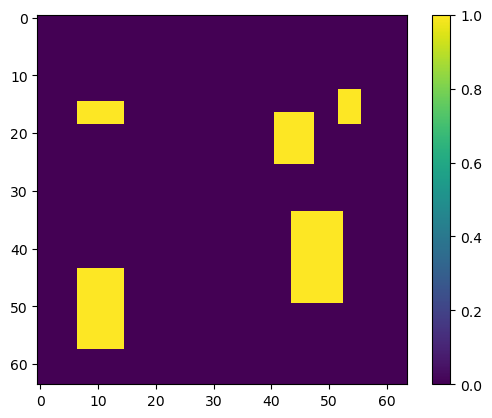

In [48]:
import numpy as np
import random

def generate_grid_with_random_rectangles(n, domain_size, grid_resolution, min_width, max_width, min_height, max_height, dist):
    domain_boundary = domain_size / 2
    rectangles = []
    while len(rectangles) < n:
        width = np.random.uniform(min_width, max_width)
        height = np.random.uniform(min_height, max_height)
        x = np.random.uniform(-domain_boundary + dist, domain_boundary - width - dist)
        y = np.random.uniform(-domain_boundary + dist, domain_boundary - height - dist)
        overlaps = False
        for rect in rectangles:
            if ((x < rect[0] + rect[2]) and (rect[0] < x + width)) and ((y < rect[1] + rect[3]) and (rect[1] < y + height)):
                overlaps = True
                break
        if not overlaps:
            rectangles.append((x, y, width, height))
    grid_size = int(domain_size / grid_resolution)
    grid = np.zeros((grid_size, grid_size))
    for rect in rectangles:
        x_start = int((rect[0] + domain_boundary) / grid_resolution)
        x_end = int((rect[0] + rect[2] + domain_boundary) / grid_resolution)
        y_start = int((rect[1] + domain_boundary) / grid_resolution)
        y_end = int((rect[1] + rect[3] + domain_boundary) / grid_resolution)
        grid[y_start:y_end, x_start:x_end] = 1
    return grid

def gen_rectangles(a, n, block_nums, min_width, max_width, min_height, max_height, dist):
    rectangles = []
    while len(rectangles) < block_nums:
        width = np.random.uniform(min_width, max_width)
        height = np.random.uniform(min_height, max_height)
        x = np.random.uniform(-a + dist, a - width - dist)
        y = np.random.uniform(-a + dist, a - height - dist)
        overlaps = False
        for rect in rectangles:
            if (x < rect[0] + rect[2]) and (rect[0] < x + width) and (y < rect[1] + rect[3]) and (rect[1] < y + height):
                overlaps = True
                break
        if not overlaps:
            rectangles.append((x, y, width, height))

    grid = np.zeros((n, n))
    h = 2 * a / (n - 1)
    for rect in rectangles:
        x_start = int((rect[0] + a) / h)
        x_end = int((rect[0] + rect[2] + a) / h)
        y_start = int((rect[1] + a) / h)
        y_end = int((rect[1] + rect[3] + a) / h)
        grid[y_start:y_end, x_start:x_end] = 1
    return grid

grid = gen_rectangles(1, 64, 5, 0.05, 0.5, 0.05, 0.5, 0.1)
plt.imshow(grid, cmap='viridis')
plt.colorbar()
plt.show()

In [8]:
def _gen_points(n, min_dist, a=1):
    points = np.empty((0, 2))
    while len(points) < n :
        new_point = np.random.uniform(-1 + min_dist, 1 - min_dist, size=(2,))
        if len(points) == 0:
            points = np.append(points, [new_point], axis=0)
            continue
        dist = np.sqrt(np.sum((points - new_point) ** 2, axis=1))
        if np.min(dist) >= min_dist:
            points = np.append(points, [new_point], axis=0)
    return points
ps = _gen_points(2, 0.1)
ps[0]

array([ 0.03430618, -0.44456682])